# Advanced `pandas`

The following notebook is dedicated to more advanved opeartions in Pandas:

- `split-apply-combine` pipeline,
- operations on string columns (string operations, replacement),
- joins on Pandas dataframes.

In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd

In [3]:
titanic_train = pd.read_csv("train.csv", index_col="PassengerId")
titanic_test = pd.read_csv("test.csv", index_col="PassengerId")
titanic = pd.concat([titanic_train, titanic_test], sort=False)

In [4]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic.groupby("Ticket").size().value_counts()

1     713
2     132
3      49
4      16
5       7
7       5
6       4
8       2
11      1
dtype: int64

In [7]:
titanic.groupby("Ticket")["Fare"].mean() / titanic.groupby("Ticket").size()

Ticket
110152         28.833333
110413         26.550000
110465         26.000000
110469         26.000000
110489         26.550000
                 ...    
W./C. 6608      6.875000
W./C. 6609      7.550000
W.E.P. 5734    30.587500
W/C 14208      10.500000
WE/P 5735      35.500000
Length: 929, dtype: float64

In [8]:
titanic.merge((titanic.groupby("Ticket")["Fare"].mean() / titanic.groupby("Ticket").size()).rename("fare_per_pass"),
              left_on="Ticket", right_index=True, how="left").groupby("Pclass")["fare_per_pass"].mean()

Pclass
1    33.910500
2    11.411010
3     7.329146
Name: fare_per_pass, dtype: float64

# Split-apply-combine (`GROUP BY` in Pandas)

Depending on how the result of `apply` part of the pipeline is structured, Pandas will `combine` differently. Many common operations have shortcuts, making them extremely concise. We start with the most simple case: `apply` results in a single scalar per group.

Entry point to Pandas grouping:

In [9]:
class_groups = titanic.groupby("Pclass")

In [10]:
class_groups

Pandas is smart enough to provide some common operations automatically:

In [11]:
class_groups.mean()
#It is smart enough to not try and calculate mean on columns which it wouldn't work on, like string

,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,
1,0.629630,39.159930,0.436533,0.365325,87.508992
2,0.472826,29.506705,0.393502,0.368231,21.179196
3,0.242363,24.816367,0.568406,0.400564,13.302889


We can group (only a single column) by a synthetic key:

In [12]:
5+ 10*(titanic.Age//10)

PassengerId
1       25.0
2       35.0
3       25.0
4       35.0
5       35.0
        ... 
1305     NaN
1306    35.0
1307    35.0
1308     NaN
1309     NaN
Name: Age, Length: 1309, dtype: float64

In [13]:
titanic["AgeGroup"] = 5 + 10*(titanic.Age//10)
titanic[["Age", "AgeGroup"]]

,Age,AgeGroup
PassengerId,,
1,22.0,25.0
2,38.0,35.0
3,26.0,25.0
4,35.0,35.0
5,35.0,35.0
...,...,...
1305,NaN,NaN
1306,39.0,35.0
1307,38.5,35.0


In [14]:
age_groups = titanic.Parch.groupby((5 + 10*(titanic.Age//10)))
#We  can also provide a sequence

In [15]:
age_groups

In [16]:
age_groups.mean().to_frame() # Note index name
#This is being transformed to a data frame.

,Parch
Age,
5.0,1.390244
15.0,0.482517
25.0,0.223837
35.0,0.314655
45.0,0.503704
55.0,0.300000
65.0,0.531250
75.0,0.142857
85.0,0.000000


NumPy arrays can also be used as grouping keys:

In [17]:
age_groups_npy = titanic.Parch.groupby((5 + 10*(titanic.Age//10)).values)
#external key can be any sequence, generally, as long as it is the same shape as the dataframe we are grouping.

In [18]:
age_groups_npy.mean().to_frame()
#In this example, this index name was not preserved (age), as opposed to above

,Parch
5.0,1.390244
15.0,0.482517
25.0,0.223837
35.0,0.314655
45.0,0.503704
55.0,0.300000
65.0,0.531250
75.0,0.142857
85.0,0.000000


### Multi-Indexing

In [24]:
age_groups_multi = titanic.Parch.groupby([(5 + 10*(titanic.Age//10)), titanic.Pclass])

In [25]:
age_groups_multi = titanic.Parch.groupby([titanic.Pclass, (5 + 10*(titanic.Age//10))])

In [26]:
age_groups_multi

In [22]:
age_groups_multi.mean()
#We returned a multi-index series, based off two groupings.

Pclass  Age 
1       5.0     2.000000
        15.0    0.863636
        25.0    0.480769
        35.0    0.250000
        45.0    0.209677
        55.0    0.369565
        65.0    0.761905
        75.0    0.250000
        85.0    0.000000
2       5.0     1.409091
        15.0    0.310345
        25.0    0.288889
        35.0    0.265625
        45.0    0.451613
        55.0    0.235294
        65.0    0.142857
        75.0    0.000000
3       5.0     1.339286
        15.0    0.445652
        25.0    0.128713
        35.0    0.395833
        45.0    0.976190
        55.0    0.000000
        65.0    0.000000
        75.0    0.000000
Name: Parch, dtype: float64

We can restructure the result:

In [23]:
age_groups_multi.mean().unstack() #unstack will move one of the levels and make it a column.
#Very often this is convenient, as it makes plotting very simple, as we will see.

Age,5.0,15.0,25.0,35.0,45.0,55.0,65.0,75.0,85.0
Pclass,,,,,,,,,
1,2.000000,0.863636,0.480769,0.250000,0.209677,0.369565,0.761905,0.25,0.0
2,1.409091,0.310345,0.288889,0.265625,0.451613,0.235294,0.142857,0.00,NaN
3,1.339286,0.445652,0.128713,0.395833,0.976190,0.000000,0.000000,0.00,NaN


We can mix column names with a real iterables:

In [27]:
age_groups_mixed = titanic.groupby([(5 + 10*(titanic.Age//10)), "Pclass", "Embarked"])

In [28]:
age_groups_mixed

In [29]:
age_groups_mixed.Parch.mean()

Age   Pclass  Embarked
5.0   1       C           2.000000
              S           2.000000
      2       C           2.000000
              S           1.315789
      3       C           1.100000
              Q           1.000000
              S           1.428571
15.0  1       C           0.875000
              S           0.857143
      2       C           0.000000
              S           0.333333
      3       C           0.312500
              Q           0.100000
              S           0.530303
25.0  1       C           0.481481
              S           0.480000
      2       C           0.416667
              S           0.269231
      3       C           0.285714
              Q           0.000000
              S           0.119048
35.0  1       C           0.156250
              Q           0.000000
              S           0.351351
      2       C           0.166667
              Q           0.000000
              S           0.285714
      3       C           0.3333

In [27]:
age_groups_mixed.Parch.mean().unstack(level=(0,2)) #level 0 is age, level 2 is embarked

Age      5.0                    15.0                     25.0                 \
Embarked    C         S    Q       C         S    Q         C         S    Q   
Pclass                                                                         
1         2.0  2.000000  NaN  0.8750  0.857143  NaN  0.481481  0.480000  NaN   
2         2.0  1.315789  NaN  0.0000  0.333333  NaN  0.416667  0.269231  NaN   
3         1.1  1.428571  1.0  0.3125  0.530303  0.1  0.285714  0.119048  0.0   

Age           35.0  ...      55.0                65.0                75.0  \
Embarked         C  ...         C         S    Q    C         S    Q    C   
Pclass              ...                                                     
1         0.156250  ...  0.347826  0.391304  NaN  1.0  0.692308  NaN  0.0   
2         0.166667  ...       NaN  0.250000  0.0  NaN  0.200000  0.0  NaN   
3         0.333333  ...       NaN  0.000000  NaN  NaN  0.000000  0.0  NaN   

Age                85.0  
Embarked    S    Q    S  
Pclass                   
1         0.5  NaN  0.0  
2         0.0  NaN  NaN  
3         0.0  0.0  NaN  

[3 rows x 25 columns]

## `apply` outputs series

In [28]:
class_groups = titanic.groupby("Pclass") # Nothing is calculated yet

In [29]:
class_groups.mean()

,Survived,Age,SibSp,Parch,Fare,AgeGroup
Pclass,,,,,,
1,0.629630,39.159930,0.436533,0.365325,87.508992,39.577465
2,0.472826,29.506705,0.393502,0.368231,21.179196,30.249042
3,0.242363,24.816367,0.568406,0.400564,13.302889,25.459082


Let's simulate series output of `apply` stage:

In [30]:
titanic.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [31]:
class_groups.Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,323.0,87.508992,80.447178,0.0,30.6958,60.0000,107.6625,512.3292
2,277.0,21.179196,13.607122,0.0,13.0000,15.0458,26.0000,73.5000
3,708.0,13.302889,11.494358,0.0,7.7500,8.0500,15.2458,69.5500


In [32]:
class_groups.apply(lambda x: x.Fare.describe()) # Note column index name
#x is a subset of the original dataframe, and we take its fare column and do describe on it.
#We see that we get the same result as the above cell, except here, the Index name is kept, because we are providing
#A Series directly to the groupby.

Fare,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,323.0,87.508992,80.447178,0.0,30.6958,60.0000,107.6625,512.3292
2,277.0,21.179196,13.607122,0.0,13.0000,15.0458,26.0000,73.5000
3,708.0,13.302889,11.494358,0.0,7.7500,8.0500,15.2458,69.5500


In [33]:
titanic.groupby("Sex").Parch.mean()

Sex
female    0.633047
male      0.247924
Name: Parch, dtype: float64

In [34]:
class_groups.apply(lambda x: x.groupby("Sex").Parch.mean()) # Note column index name

Sex,female,male
Pclass,,
1,0.472222,0.279330
2,0.650943,0.192982
3,0.731481,0.255578


In [35]:
class_groups.apply(lambda x: x[x.Parch==0].groupby("Sex").size()) #remove those who don'y have parents or children

Sex,female,male
Pclass,,
1,97,145
2,61,145
3,135,419


The same can be achieved differently, of course:

In [36]:
titanic[titanic.Parch==0].groupby(["Pclass", "Sex"]).size().unstack()
#Remove the ones who don't have childten, group by pclass and then sex, do the size function on it, then unstack.

Sex,female,male
Pclass,,
1,97,145
2,61,145
3,135,419


What if `apply` result has multi-index on it's own?

In [37]:
titanic[titanic.Parch!=0].groupby(["Sex", "Embarked"]).size()

Sex     Embarked
female  C            42
        Q             3
        S           128
male    C            32
        Q             6
        S            96
dtype: int64

In [38]:
class_groups.apply(lambda x: x[x.Parch!=0].groupby(["Sex", "Embarked"]).size())

Pclass  Sex     Embarked
1       female  C           21
                S           26
        male    C           18
                S           16
2       female  C            4
                S           41
        male    C            3
                S           23
3       female  C           17
                Q            3
                S           61
        male    C           11
                Q            6
                S           57
dtype: int64

In [39]:
result_s = (class_groups
            .apply(lambda x: x[x.Parch!=0].groupby(["Sex", "Embarked"]).size()))

In [40]:
result = (class_groups
          .apply(lambda x: x[x.Parch!=0].groupby(["Sex", "Embarked"]).size())
          .unstack([1,2]))
          #We unstack on level 1 and level 2

In [41]:
result

Sex      female        male       female male
Embarked      C     S     C     S      Q    Q
Pclass                                       
1          21.0  26.0  18.0  16.0    NaN  NaN
2           4.0  41.0   3.0  23.0    NaN  NaN
3          17.0  61.0  11.0  57.0    3.0  6.0

### Intermezzo: indexing a multi-indexed dataframe

the general rule is that for multi index, you need to provide a tuple. THen, if you want to take specific columns based off that tuple, you provide a list and then tuples within it.

In [42]:
result.loc[:, ("female", "C")]

Pclass
1    21.0
2     4.0
3    17.0
Name: (female, C), dtype: float64

In [43]:
result.loc[:, [("female", "C"), ("female", "S")]]

Sex      female      
Embarked      C     S
Pclass               
1          21.0  26.0
2           4.0  41.0
3          17.0  61.0

Positional index is slightly different, as it known nothing about multi-index *per se*:

In [44]:
result.iloc[:, [0, 1]]

Sex      female      
Embarked      C     S
Pclass               
1          21.0  26.0
2           4.0  41.0
3          17.0  61.0

## DataFrame output

In [45]:
titanic[["SibSp", "Parch"]].head()


,SibSp,Parch
PassengerId,,
1,1,0
2,1,0
3,0,0
4,1,0
5,0,0


In [46]:
#To simulate  a dataframe result from an apply operation, we will take columns and apply averages on them
(titanic[titanic.Parch!=0]
 .groupby(["Sex", "Embarked"])[["SibSp", "Parch"]] #group by sex and embarked, and then take the mean of sibsip and parch
 .mean())

SibSp     Parch
Sex    Embarked                    
female C         0.619048  1.380952
       Q         0.333333  2.666667
       S         1.304688  1.789062
male   C         0.562500  1.312500
       Q         3.500000  1.000000
       S         1.833333  1.677083

In [47]:
class_groups

In [48]:
#Same operation, just per group
(class_groups
 .apply(lambda x: x[x.Parch!=0].groupby(["Sex", "Embarked"])[["SibSp", "Parch"]]
        .mean()))

SibSp     Parch
Pclass Sex    Embarked                    
1      female C         0.523810  1.285714
              S         0.807692  1.576923
       male   C         0.444444  1.388889
              S         0.875000  1.562500
2      female C         1.000000  1.750000
              S         0.682927  1.512195
       male   C         0.666667  1.666667
              S         0.869565  1.217391
3      female C         0.647059  1.411765
              Q         0.333333  2.666667
              S         1.934426  2.065574
       male   C         0.727273  1.090909
              Q         3.500000  1.000000
              S         2.491228  1.894737

In [49]:
#Same result as above, just without apply. Adds in pclass to the groupby
(titanic[titanic.Parch!=0]
 .groupby(['Pclass', "Sex", "Embarked"])[["SibSp", "Parch"]] #group by sex and embarked, and then take the mean of sibsip and parch
 .mean())

SibSp     Parch
Pclass Sex    Embarked                    
1      female C         0.523810  1.285714
              S         0.807692  1.576923
       male   C         0.444444  1.388889
              S         0.875000  1.562500
2      female C         1.000000  1.750000
              S         0.682927  1.512195
       male   C         0.666667  1.666667
              S         0.869565  1.217391
3      female C         0.647059  1.411765
              Q         0.333333  2.666667
              S         1.934426  2.065574
       male   C         0.727273  1.090909
              Q         3.500000  1.000000
              S         2.491228  1.894737

## Mixing group keys

Often we need to mix the keys...

In [50]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup
PassengerId,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,25.0
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,35.0
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,25.0
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0


In [51]:
titanic_idx = titanic.reset_index().set_index((5 + 10*(titanic.Age//10)))
#remove the original index, and set a new one.

In [52]:
titanic_idx.head()
#Now, we have a grouping key

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup
Age,,,,,,,,,,,,,
25.0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,25.0
35.0,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,35.0
25.0,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,25.0
35.0,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0
35.0,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0


`pd.Grouper` is an entry point to complex mixed groupings:

In [53]:
pd.Grouper?
#pd.Grouper is a shortcut to combining more or less what you want. It allows you to make grouping keys on datatime, levels, columns, whatever.
#So if something can't be represtned as a list of keys, it can be represtned as a grouper. For example, I want a weekly key
#on a column, and we on our own don't do any calculations.
#We use it more or less striaghtifrowadly

Init signature: pd.Grouper(*args, **kwargs)
Docstring:     
A Grouper allows the user to specify a groupby instruction for an object.

This specification will select a column via the key parameter, or if the
level and/or axis parameters are given, a level of the index of the target
object.

If `axis` and/or `level` are passed as keywords to both `Grouper` and
`groupby`, the values passed to `Grouper` take precedence.

Parameters
----------
key : str, defaults to None
    Groupby key, which selects the grouping column of the target.
level : name/number, defaults to None
    The level for the target index.
freq : str / frequency object, defaults to None
    This will groupby the specified frequency if the target selection
    (via key or level) is a datetime-like object. For full specification
    of available frequencies, please see `here
    <https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases>`_.
axis : str, int, defaults to 0
    Number/name of the 

In [54]:
titanic_idx.groupby([pd.Grouper(level="Age"), "Pclass"]).Parch.mean()

Age   Pclass
5.0   1         2.000000
      2         1.409091
      3         1.339286
15.0  1         0.863636
      2         0.310345
      3         0.445652
25.0  1         0.480769
      2         0.288889
      3         0.128713
35.0  1         0.250000
      2         0.265625
      3         0.395833
45.0  1         0.209677
      2         0.451613
      3         0.976190
55.0  1         0.369565
      2         0.235294
      3         0.000000
65.0  1         0.761905
      2         0.142857
      3         0.000000
75.0  1         0.250000
      2         0.000000
      3         0.000000
85.0  1         0.000000
Name: Parch, dtype: float64

In [55]:
titanic_idx.index

Float64Index([25.0, 35.0, 25.0, 35.0, 35.0,  nan, 55.0,  5.0, 25.0, 15.0,
              ...
               nan,  5.0,  nan, 35.0, 25.0,  nan, 35.0, 35.0,  nan,  nan],
             dtype='float64', name='Age', length=1309)

In [56]:
titanic_idx.groupby([titanic_idx.index, "Pclass"]).Parch.mean()

Age   Pclass
5.0   1         2.000000
      2         1.409091
      3         1.339286
15.0  1         0.863636
      2         0.310345
      3         0.445652
25.0  1         0.480769
      2         0.288889
      3         0.128713
35.0  1         0.250000
      2         0.265625
      3         0.395833
45.0  1         0.209677
      2         0.451613
      3         0.976190
55.0  1         0.369565
      2         0.235294
      3         0.000000
65.0  1         0.761905
      2         0.142857
      3         0.000000
75.0  1         0.250000
      2         0.000000
      3         0.000000
85.0  1         0.000000
Name: Parch, dtype: float64

### Intermezzo: on `size` vs. `count`

`size` is a method to get, you name it, **size** of something, in this case, of a group:

In [57]:
titanic.groupby('Pclass').size()  ## how many elements are in each group

Pclass
1    323
2    277
3    709
dtype: int64

But you **count** only something specific:

In [58]:
titanic.groupby('Pclass').count()

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup
Pclass,,,,,,,,,,,
1,216,323,323,284,323,323,323,323,256,321,284
2,184,277,277,261,277,277,277,277,23,277,261
3,491,709,709,501,709,709,709,708,16,709,501


As you can see, `count` only counts non-missing values, i.e. something, that is present in the dataframe. Hence, a bit more elaborated way of getting (almost) the same is:

In [59]:
titanic.isnull()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup
PassengerId,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,True,False,False,False,True,False,False,False,False,True,False,True
1306,True,False,False,False,False,False,False,False,False,False,False,False
1307,True,False,False,False,False,False,False,False,False,True,False,False


In [60]:
titanic.groupby('Pclass').apply(lambda group: group.notnull().sum())
#This is the same as .count()-- sums all of the non-null values

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup
Pclass,,,,,,,,,,,,
1,216,323,323,323,284,323,323,323,323,256,321,284
2,184,277,277,277,261,277,277,277,277,23,277,261
3,491,709,709,709,501,709,709,709,708,16,709,501


# How `S-A-C` is important in exploratory data analysis

There are no exact methods for explaratory analysis- anything you can do with a data set to understand it better, works. Its all subjective to what you are trying to understand from your data.

In [61]:
titanic.Pclass.value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [62]:
#We won't work on the original age, because there is no reasonable grouping of it-- its float, and too find grained.
titanic["AgeGroup"] = 5 + 10*(titanic.Age//10)
titanic[["Age", "AgeGroup"]]

,Age,AgeGroup
PassengerId,,
1,22.0,25.0
2,38.0,35.0
3,26.0,25.0
4,35.0,35.0
5,35.0,35.0
...,...,...
1305,NaN,NaN
1306,39.0,35.0
1307,38.5,35.0


Let's calculate something non-trivial. For example, percentage of each age group and sex combination, per class:

In [63]:
titanic_dna = titanic[titanic.Age.notnull()]  #remove all rows that have null values in age.
# it's a matter of discussion, if we need this: think on it a bit
group_counts = titanic_dna.groupby(['Pclass', 'AgeGroup', 'Sex']).size()/titanic_dna.groupby('Pclass').size()
#calculate a ratio between each group and each Pclass. 
group_counts.head()
#the percentages, for example the 0.0528, is the amount of females of 15 specifically in Pclass 1, not all pasengers.

Pclass  AgeGroup  Sex   
1       5.0       female    0.003521
                  male      0.010563
        15.0      female    0.052817
                  male      0.024648
        25.0      female    0.095070
dtype: float64

In [64]:
group_counts.unstack(level=1) #We can also do level 2 to unstack on sex, depending on what you want to see.

AgeGroup           5.0       15.0      25.0      35.0      45.0      55.0  \
Pclass Sex                                                                  
1      female  0.003521  0.052817  0.095070  0.133803  0.077465  0.073944   
       male    0.010563  0.024648  0.088028  0.119718  0.140845  0.088028   
2      female  0.042146  0.049808  0.145594  0.084291  0.045977  0.022989   
       male    0.042146  0.061303  0.199234  0.160920  0.072797  0.042146   
3      female  0.053892  0.071856  0.099800  0.051896  0.023952       NaN   
       male    0.057884  0.111776  0.303393  0.139721  0.059880  0.013972   

AgeGroup           65.0      75.0      85.0  
Pclass Sex                                   
1      female  0.028169  0.003521       NaN  
       male    0.045775  0.010563  0.003521  
2      female  0.003831       NaN       NaN  
       male    0.022989  0.003831       NaN  
3      female  0.001996       NaN       NaN  
       male    0.005988  0.003992       NaN

A simple way to validate the calculation:

In [65]:
group_counts.groupby(level=0).sum()

Pclass
1    1.0
2    1.0
3    1.0
dtype: float64

Main advantage of Pandas for EDA comes from very flexible inter-operability of analytics and plotting:

In [66]:
group_counts = group_counts.unstack()

In [67]:
group_counts

Sex                female      male
Pclass AgeGroup                    
1      5.0       0.003521  0.010563
       15.0      0.052817  0.024648
       25.0      0.095070  0.088028
       35.0      0.133803  0.119718
       45.0      0.077465  0.140845
       55.0      0.073944  0.088028
       65.0      0.028169  0.045775
       75.0      0.003521  0.010563
       85.0           NaN  0.003521
2      5.0       0.042146  0.042146
       15.0      0.049808  0.061303
       25.0      0.145594  0.199234
       35.0      0.084291  0.160920
       45.0      0.045977  0.072797
       55.0      0.022989  0.042146
       65.0      0.003831  0.022989
       75.0           NaN  0.003831
3      5.0       0.053892  0.057884
       15.0      0.071856  0.111776
       25.0      0.099800  0.303393
       35.0      0.051896  0.139721
       45.0      0.023952  0.059880
       55.0           NaN  0.013972
       65.0      0.001996  0.005988
       75.0           NaN  0.003992

C:\Users\sfrie\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\sfrie\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


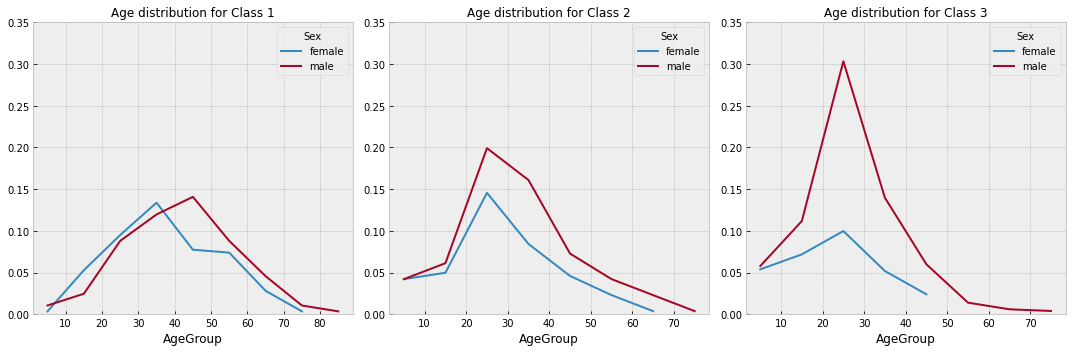

In [68]:
#This is the manual way to plot. Later, we will do this in a much simpler way
plt.figure(figsize=(15, 5))

for pclass in [1, 2, 3]:
    plt.subplot(1, 3, pclass)
    group_counts.loc[pclass].plot(ax=plt.gca()) #take groupcounts by the class, and plot it.
    plt.ylim(0, 0.35)
    plt.title("Age distribution for Class %i" % pclass, fontsize=12)
plt.tight_layout()

The difference between the plots in class 1 and 2 are not so pronounced.
However, 1 and 2 differ with 3 dramatically, with high domination of males, and from the lack of women, we see its a lot of males who travel alone.

Also, the average age of the males is very different for each class, with class 1 being pretty semetric, 2 being a bit of an older class, and 3 being very young.

Note, its very easy to come to speculative conclusions from these shapes, but its important to not build pre-conceptions right away. Or minimally, be ready to drop them when presented with contradictory data.

In [69]:
survival_groups = titanic.groupby(['Pclass', 'AgeGroup', 'Sex']).Survived.mean()
survival_groups

Pclass  AgeGroup  Sex   
1       5.0       female    0.000000
                  male      1.000000
        15.0      female    1.000000
                  male      0.400000
        25.0      female    0.937500
                  male      0.500000
        35.0      female    1.000000
                  male      0.521739
        45.0      female    1.000000
                  male      0.375000
        55.0      female    0.916667
                  male      0.266667
        65.0      female    1.000000
                  male      0.100000
        75.0      female         NaN
                  male      0.000000
        85.0      male      1.000000
2       5.0       female    1.000000
                  male      1.000000
        15.0      female    1.000000
                  male      0.100000
        25.0      female    0.880000
                  male      0.000000
        35.0      female    0.941176
                  male      0.096774
        45.0      female    0.900000
             

In [70]:
survival_groups = survival_groups.unstack()
#unstacks the same way: by Pclass

C:\Users\sfrie\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\sfrie\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


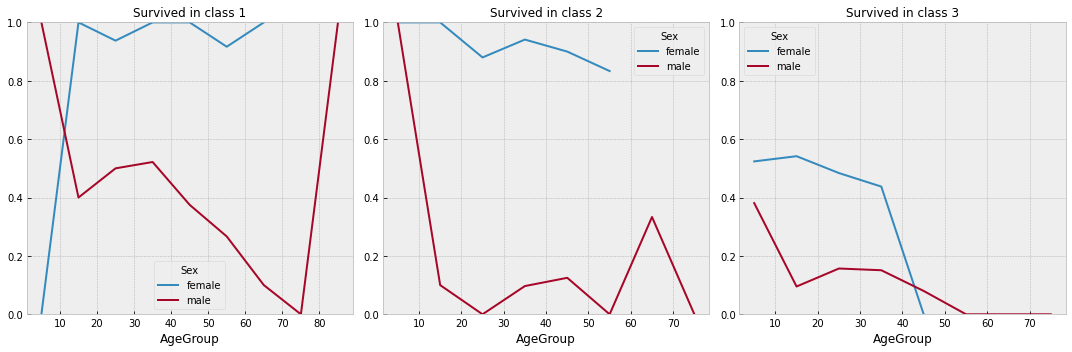

In [71]:
plt.figure(figsize=(15, 5))

for pclass in [1, 2, 3]:
    plt.subplot(1, 3, pclass)
    survival_groups.loc[pclass].plot(ax=plt.gca())
    plt.ylim(0, 1)
    plt.title("Survived in class %i" % pclass, fontsize=12)
plt.tight_layout()

In [72]:
siblings_groups = titanic.groupby(['Pclass', 'AgeGroup', 'Sex']).SibSp.mean()
siblings_groups = siblings_groups.unstack()

In [73]:
siblings_groups

Sex                female      male
Pclass AgeGroup                    
1      5.0       1.000000  0.333333
       15.0      0.600000  1.142857
       25.0      0.703704  0.320000
       35.0      0.394737  0.323529
       45.0      0.500000  0.375000
       55.0      0.619048  0.480000
       65.0      0.625000  0.384615
       75.0      1.000000  0.333333
       85.0           NaN  0.000000
2      5.0       0.818182  0.818182
       15.0      0.384615  0.062500
       25.0      0.631579  0.384615
       35.0      0.363636  0.380952
       45.0      0.416667  0.315789
       55.0      0.166667  0.181818
       65.0      1.000000  0.333333
       75.0           NaN  0.000000
3      5.0       1.666667  2.413793
       15.0      0.777778  0.964286
       25.0      0.300000  0.171053
       35.0      0.653846  0.185714
       45.0      0.583333  0.200000
       55.0           NaN  0.142857
       65.0      0.000000  0.000000
       75.0           NaN  0.000000

C:\Users\sfrie\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\sfrie\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


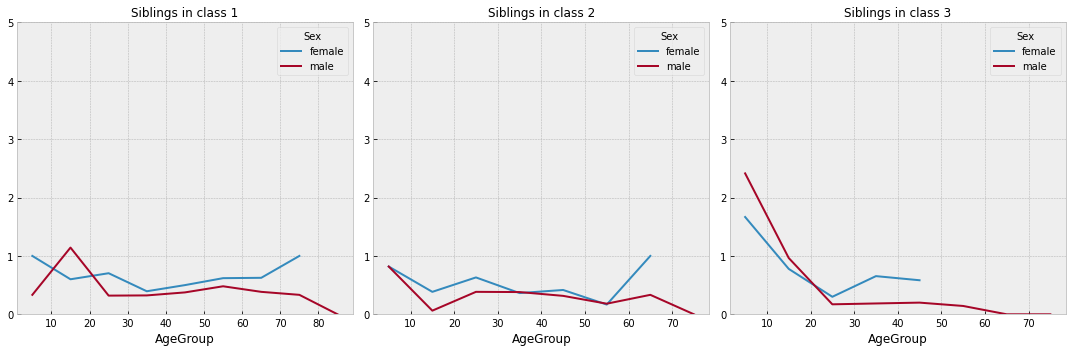

In [74]:
plt.figure(figsize=(15, 5))

for pclass in [1, 2, 3]:
    plt.subplot(1, 3, pclass)
    siblings_groups.loc[pclass].plot(ax=plt.gca())
    plt.ylim(0, 5)
    plt.title("Siblings in class %i" % pclass, fontsize=12)
plt.tight_layout()

IN class 1: between 20-60, its probably mostly spouses, therefore half the passengers travel with spouses. This is more or less the same for class 2.

In class 3 though, we see a nice disparity between male and female, just emphasizing what we saw above: In class 3, there are lots of single males.

Note though, that females in class 3 is pretty high. However, we also know that there aren't so many females in class 3, so the data might not be so telling

In [75]:
embark_counts = titanic.groupby(['Pclass', 'AgeGroup', 'Sex', 'Embarked']).size()/titanic.groupby('Pclass').size()

embark_counts

Pclass  AgeGroup  Sex     Embarked
1       5.0       female  S           0.003096
                  male    C           0.003096
                          S           0.006192
        15.0      female  C           0.015480
                          S           0.030960
                                        ...   
3       65.0      female  S           0.001410
                  male    Q           0.001410
                          S           0.002821
        75.0      male    Q           0.001410
                          S           0.001410
Length: 94, dtype: float64

In [76]:
embark_counts = embark_counts.unstack([-1, -2]) #unstack by last two columns
embark_counts

Embarked                S         C         S         C         Q          
Sex                female      male      male    female    female      male
Pclass AgeGroup                                                            
1      5.0       0.003096  0.003096  0.006192       NaN       NaN       NaN
       15.0      0.030960  0.009288  0.012384  0.015480       NaN       NaN
       25.0      0.043344  0.043344  0.034056  0.040248       NaN       NaN
       35.0      0.052632  0.043344  0.061920  0.055728  0.006192       NaN
       45.0      0.024768  0.043344  0.077399  0.043344       NaN  0.003096
       55.0      0.027864  0.034056  0.043344  0.037152       NaN       NaN
       65.0      0.012384  0.012384  0.027864  0.009288       NaN       NaN
       75.0      0.003096  0.006192  0.003096       NaN       NaN       NaN
       85.0           NaN       NaN  0.003096       NaN       NaN       NaN
2      5.0       0.032491  0.003610  0.036101  0.007220       NaN       NaN
       15.0      0.039711       NaN  0.057762  0.007220       NaN       NaN
       25.0      0.115523  0.021661  0.166065  0.021661       NaN       NaN
       35.0      0.072202  0.018051  0.129964  0.003610  0.003610  0.003610
       45.0      0.043321  0.003610  0.064982       NaN       NaN       NaN
       55.0      0.021661       NaN  0.036101       NaN       NaN  0.003610
       65.0      0.003610       NaN  0.014440       NaN       NaN  0.007220
       75.0           NaN       NaN  0.003610       NaN       NaN       NaN
3      5.0       0.028209  0.004231  0.031030  0.009873       NaN  0.005642
       15.0      0.025388  0.008463  0.067701  0.014104  0.011283  0.002821
       25.0      0.059238  0.026798  0.177715  0.002821  0.008463  0.009873
       35.0      0.025388  0.011283  0.081805  0.001410  0.009873  0.005642
       45.0      0.014104  0.002821  0.036671  0.002821       NaN  0.002821
       55.0           NaN       NaN  0.009873       NaN       NaN       NaN
       65.0      0.001410       NaN  0.002821       NaN       NaN  0.001410
       75.0           NaN       NaN  0.001410       NaN       NaN  0.001410

### Intermezzo: Seaborn in EDA

In [77]:
import seaborn as sns

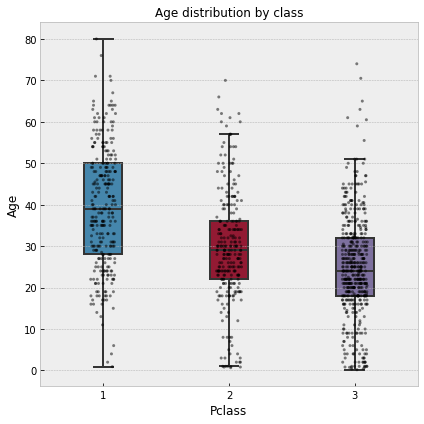

In [78]:
plt.figure(figsize=(6,6))

# We will plot jittered version of the data, hence we remove fliers
sns.boxplot(x="Pclass", y="Age", data=titanic,
            fliersize=0, width=0.3)
sns.stripplot(x="Pclass", y="Age", data=titanic, #stipplot are the individual points. Then, they are just jittered
                                                #right and left so that we can actually see them.
              color="k", alpha=0.5, size=3)
plt.title("Age distribution by class", fontsize=12)
plt.tight_layout();

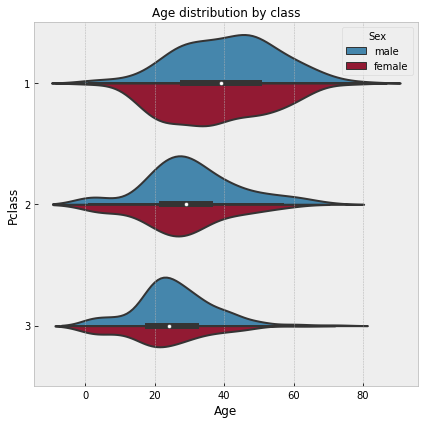

In [79]:
plt.figure(figsize=(6,6))

sns.violinplot(x="Age", y="Pclass", data=titanic,
               split=True, hue="Sex", scale="count", orient="h")
plt.title("Age distribution by class", fontsize=12)
plt.tight_layout();

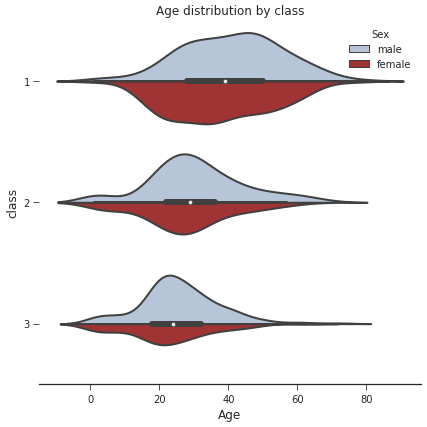

In [80]:
with plt.style.context("seaborn-ticks"):
    plt.figure(figsize=(6,6))

    sns.violinplot(x="Age", y="Pclass", data=titanic,
                   split=True, hue="Sex", scale="count", orient="h",
                   palette={"male": "lightsteelblue", "female": "firebrick"})
    plt.title("Age distribution by class", fontsize=12)

    sns.despine(left=True)

    plt.ylabel("class")

    plt.tight_layout();

For comparison:

C:\Users\sfrie\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\sfrie\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


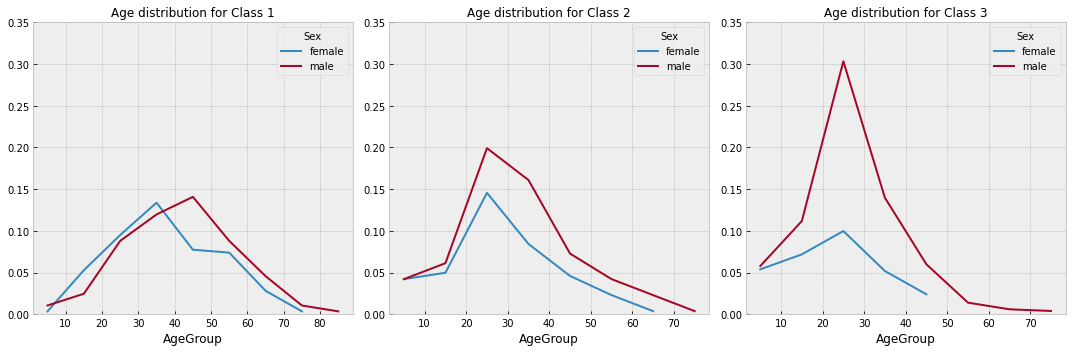

In [81]:
plt.figure(figsize=(15, 5))

for pclass in [1, 2, 3]:
    plt.subplot(1, 3, pclass)
    group_counts.loc[pclass].plot(ax=plt.gca())
    plt.ylim(0, 0.35)
    plt.title("Age distribution for Class %i" % pclass, fontsize=12)
plt.tight_layout()

This is the same exact information, but seaborn makes it much easier, and much better visually